In [1]:
from datetime import time, datetime

import numpy as np
import torch
# import os
import gzip
import matplotlib.pyplot as plt
import torch.nn.functional as F
from keras.layers.preprocessing.image_preprocessing import transform
from keras.src.ops import dtype
from tensorboard import summary

from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

# from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    # torch.cuda.is_available()
    # torch.cuda.device_count()
    # torch.cuda.current_device()
    # torch.cuda.device(0)
    # torch.cuda.get_device_name(0)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using device: cpu
Using mps device


Each training and test example is assigned to one of the following labels:
|Label|Description|
|-|-----|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

In [3]:
M_LABEL = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
           5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [4]:
def load_data(kind: str) -> tuple[np.ndarray, np.ndarray]:
    fashion_mnist_path = "/data/sample/fashion_mnist"
    images_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-images-idx3-ubyte.gz"])
    labels_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-labels-idx1-ubyte.gz"])
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

    return images, labels

In [5]:
X_train, Y_train = load_data(kind='train')
X_test, Y_test = load_data(kind='t10k')

In [6]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", Y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [7]:
X_train, X_test = X_train / 255.0, X_test / 255.0

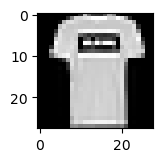

Y_train[1]:0: T-shirt/top


In [8]:
ind = 1
fig, ax = plt.subplots(figsize=(1.5, 1.5))
ax.imshow(X=X_train[ind], cmap="gray")
plt.show()
print(f"Y_train[{ind}]:{Y_train[ind]}: {M_LABEL[Y_train[ind]]}")

### 1. PyTorch

#### 1.1. Define model:

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            # nn.Softmax(dim=1)
        )
        return

    def forward(self, x):
        """
        Override forward pass ()
        :param x: x input data 
        :return: 
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # return logits
        return F.log_softmax(logits, dim=1)

In [10]:
model_nn = NeuralNetwork().to(device)
print(model_nn)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


#### 1.2. Define Train and Test functions:

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer_g = torch.optim.Adam(params=model_nn.parameters(), lr=1e-3)

In [12]:
def train_nn(dataloader: DataLoader, model: nn.Module, loss_fn: CrossEntropyLoss, optimizer: Optimizer) -> None:
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device=device), y.to(device=device)
        # reset grad before start new batch
        optimizer.zero_grad()   
        # Compute prediction error
        pred:torch.Tensor = model(X)
        loss:torch.Tensor = loss_fn(pred, y)
        # Backpropagation
        loss.backward()     # calculate the final grad to first grad
        optimizer.step()    # update W and b
        
        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return

In [13]:
def test_nn(dataloader: DataLoader, model: nn.Module, loss_fn: CrossEntropyLoss) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device=device), y.to(device=device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_probab: torch.Tensor = nn.Softmax(dim=1)(pred)
            correct += (pred_probab.argmax(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)
        # self.sequence = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),   # by default: stride = 1
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5),
        #     nn.MaxPool2d(kernel_size=2),    # by default: kernel_size = stride 
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(in_features=2048, out_features=64), # in_features = 2048 will be calculated automatically
        #     nn.Linear(in_features=64, out_features=10),
        #     # nn.LogSoftmax(dim=1), # ~ SparseCategoricalCrossEntropy
        #     nn.LogSigmoid()
        # )
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),   # (28-5+1) x (28-5+1) = 24 x 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (24/2) x (24/2) = 12 x 12
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),  # (12-5+1) x (12-5+1) = 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # (8/2) x (8/2) = 4 x 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 4 * 4, out_features=128),  # 32 kênh, kích thước 4x4
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)  # 10 lớp (0-9) cho Fashion MNIST
        )

    def forward(self, x):
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = x.view(-1, 320)
        # print(f"--x.shape: {x.shape}")
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        # return self.sequence(x)
        # return F.log_softmax(x(self.sequence(x)), dim=1)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [15]:
model_cnn = CNNModel().to(device)
loss_func_cnn = nn.CrossEntropyLoss()
optimizer_g_cnn = torch.optim.Adam(params=model_cnn.parameters(), lr=1e-3)

In [16]:
def train_cnn(train_loader, model, optimizer, epoch):
    size = len(train_loader.dataset)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Xóa gradient
        output = model(data)  # Forward pass
        # loss = F.nll_loss(output, target)  # Tính toán loss
        loss = loss_func_cnn(output, target)
        loss.backward()  # Backpropagation
        optimizer.step()  # Cập nhật các tham số
        if batch_idx % 1000 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(data)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Kiểm tra mô hình trên tập test
def test_cnn(test_loader, model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss += loss_func(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    # print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    print(f"Test Error:\nAccuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### 1.3. Perform train:

In [17]:
rand_seed = np.random.randint(low=0, high=1000)
X_train_20 = train_test_split(X_train, test_size=0.2, random_state=rand_seed)[1]
Y_train_20 = train_test_split(Y_train, test_size=0.2, random_state=rand_seed)[1]
rand_seed = np.random.randint(low=0, high=1000)
X_test_20 = train_test_split(X_train, test_size=0.1, random_state=rand_seed)[1]
Y_test_20 = train_test_split(Y_train, test_size=0.1, random_state=rand_seed)[1]

In [18]:
class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform
    def __len__(self):
        return len(self.tensor_dataset)
    def __getitem__(self, idx):
        sample, label = self.tensor_dataset[idx]
        if self.transform:
            sample = self.transform(sample)
            pass
        return sample, label

In [19]:
epochs = 50
batch_size = 32
transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.ToPILImage(),
    # transforms.PILToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])
X_train_tensor, Y_train_tensor = torch.from_numpy(X_train_20).unsqueeze(dim=1).to(dtype=torch.float32), torch.from_numpy(Y_train_20).to(dtype=torch.int64)
X_test_tensor, Y_test_tensor = torch.from_numpy(X_test_20).float().unsqueeze(dim=1).to(dtype=torch.float32), torch.from_numpy(Y_test_20).to(dtype=torch.int64)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
# train_dataset = TransformedTensorDataset(train_dataset, transform=transform)
# test_dataset = TransformedTensorDataset(test_dataset, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # start_nn = datetime.now()
    # train_nn(train_dataloader, model, loss_func, optimizer_g)
    # end_nn = datetime.now()
    # test_nn(test_dataloader, model, loss_func)
    start_cnn = datetime.now()
    train_cnn(train_dataloader, model_cnn, optimizer_g_cnn, t)
    end_cnn = datetime.now()
    test_cnn(test_dataloader, model_cnn)
    # print(f"NN: {(end_nn - start_nn).total_seconds()} CNN: {(end_cnn - start_cnn).total_seconds()}")
print("Done!")

Epoch 1
-------------------------------
loss: 2.293019  [   32/12000]
Test Error:
Accuracy: 79.4%, Avg loss: 0.017459 

Epoch 2
-------------------------------
loss: 0.670650  [   32/12000]


KeyboardInterrupt: 

In [ ]:
summary(model=model_cnn)
# X_train_tensor.shape

In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model_nn(X)
pred_probab: torch.Tensor = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(dim=1)
print(f"Predicted class: {y_pred}")

In [ ]:
ts = torch.from_numpy(X_test).float()


In [ ]:
torch.manual_seed(1729)
r1 = torch.rand(2, 2)
print('A random tensor:')
print(r1)